# Experiments on real datasets 

Including preprocessing of data and comparison of different models with different metrics.

#### Datsets used
1. [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))
    - 569 samples (no missing values),
    - 30 features (removed 9 features with correlation > 0.9), 
    - 2 classes
    - 357 benign, 212 malignant
2. [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/data)
    - 891 samples (no missing values),
    - 11 features (removed 2 features with correlation > 0.9), 
    - 2 classes
    - 549 died, 342 survived

#### Metrics used
1. Accuracy
2. Precision
3. Recall
4. F1 Score
5. Bootstrap accuracy

#### Models used
1. KNN - K-Nearest Neighbors
2. LDA - Linear Discriminant Analysis
3. Logistic Regression
4. Logistic Regression with IRLS (our model)
5. Logistic Regression with IRLS (our model) with all possible interactions
6. QDA - Quadratic Discriminant Analysis

## Models and metrics

In [1]:
import pandas as pd
from functools import partial
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from LogisticRegressionIRLS import LR
from sklearn.neighbors import KNeighborsClassifier

class LRWrapper(LR):
    def __init__(self, *args, all_interactions=False, **kwargs):
        self.all_interactions = all_interactions
        super().__init__(*args, **kwargs)

    def fit(self, X, Y):
        X = pd.DataFrame(X)
        Y = Y.reshape(-1, 1)
        if self.all_interactions:
            interactions = [[i, j] for i in range(X.shape[1]) for j in range(i+1, X.shape[1])]
            super().fit(X, Y, interactions=interactions)
        else:
            super().fit(X, Y)
        return self
    
    def predict(self, X):
        X = pd.DataFrame(X)
        Y = super().predict(X)
        return Y

models = {'LDA': LinearDiscriminantAnalysis,
        'QDA': QuadraticDiscriminantAnalysis,
        'Logistic ': LogisticRegression,
        'Logistic IRLS': partial(LRWrapper, maximisation_minorisation=True),
        'Logistic IRLS with interactions': partial(LRWrapper, maximisation_minorisation=True, all_interactions=True),
        'KNN': KNeighborsClassifier}

In [2]:
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def metric_bootstrap(X, Y, model_class, n=10):
    model = model_class()
    error = 0
    lenght_of_y = 0
    for i in range(n):
        sample_ids = resample(range(len(X)), replace=True, n_samples=len(X))

        test_ids = [i for i in range(len(X)) if i not in sample_ids]
        if len(sample_ids) == len(test_ids):
            i -= 1
            continue
        lenght_of_y += len(test_ids)
        train_ids = [i for i in range(len(X)) if i in sample_ids]
        model.fit(X[train_ids], Y[train_ids])
        y_pred = model.predict(X[test_ids])
        for i in range(len(y_pred)):
            if Y[test_ids[i]] != y_pred[i]:
                error += 1
    error_bootstrap = error / lenght_of_y
    accuracy_bootstrap = 1 - error_bootstrap
    return accuracy_bootstrap

metrics = {'precision': partial(precision_score, zero_division=0),
            'recall': recall_score,
            'accuracy': accuracy_score,
            'f1': f1_score,
            'bootstrap': metric_bootstrap}

In [3]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter(action='ignore', category=ConvergenceWarning)

from sklearn.model_selection import train_test_split


def train_model(model_class, X_train, X_test, Y_train, Y_test, metrics, model_name='model'):
    model = model_class()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return {'model':model_name} |\
            {metric: metrics[metric](Y_test, Y_pred) for metric in metrics if metric != 'bootstrap'} |\
            {f'bootstrap accuracy': metrics['bootstrap'](X_train, Y_train, model_class)}

def train_models(models, X, Y, metrics, test_size):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
    results = []
    for model_name, model_class in models.items():
        results.append(train_model(model_class, X_train, X_test, Y_train, Y_test, metrics, model_name=model_name))
    df = pd.DataFrame(results)
    return df

## Dataset 1 - Breast Cancer

Source: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))

In [4]:
from sklearn.datasets import load_breast_cancer

X, Y = load_breast_cancer(return_X_y=True)
df = pd.DataFrame(data=np.hstack((X, Y.reshape(-1, 1))), columns=list(load_breast_cancer().feature_names) + ['target'])
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


## Preparing data

In [5]:
from collinearity import SelectNonCollinear
from sklearn.preprocessing import StandardScaler

def remove_colinear(X, correlation_threshold=0.9):
    # Source: https://github.com/gianlucamalato/collinearity
    # 1. Take the couple of features that have the lowest absolute 
    #    value of the linear correlation coefficient.
    # 2. If it's lower than the threshold, consider these features
    # 3. Keep adding features as long as the correlation matrix doesn't
    #    show off-diagonal elements whose absolute value is greater than the threshold.
    selector = SelectNonCollinear(correlation_threshold=correlation_threshold)
    selector.fit(X, y=None)
    X = selector.transform(X)
    columns_selection = selector.get_support()
    return X, columns_selection   

def scale_features(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X

Before preparation:

In [6]:
print(f"In the raw data, there are {X.shape[0]} observations and {X.shape[1]} features.")

In the raw data, there are 569 observations and 30 features.


Dropping features with correlation > 0.9, and scaling the data. This dataset does not contain missing values or categorical features.

In [7]:
X, columns_selection = remove_colinear(X, correlation_threshold=0.9)
X = scale_features(X)

After preparation:

In [8]:
print(f"In the prepared data, there are {X.shape[0]} observations and {X.shape[1]} features (removed {len(columns_selection) - np.array(columns_selection).sum()} features).")

In the prepared data, there are 569 observations and 21 features (removed 9 features).


## Experiments

Test run.

In [9]:
train_models(models, X, Y, metrics, test_size=0.2)

/mnt/Data/studies/py_projects/aml_project/Logistic-Regression-with-IRLS/LogisticRegressionIRLS.py:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(X @ β))


,model,precision,recall,accuracy,f1,bootstrap accuracy
0,LDA,0.935065,1.000000,0.956140,0.966443,0.954792
1,QDA,0.986111,0.986111,0.982456,0.986111,0.931425
2,Logistic,0.960000,1.000000,0.973684,0.979592,0.967026
3,Logistic IRLS,0.986301,1.000000,0.991228,0.993103,0.953333
4,Logistic IRLS with interactions,0.924242,0.847222,0.859649,0.884058,0.730514
5,KNN,0.959459,0.986111,0.964912,0.972603,0.964976


Repeated 10 times to create boxplots.

In [10]:
from tqdm import tqdm

test_size = 0.6 # it is this high to see differences in the results
REPETITIONS = 10

df_list = []
for i in tqdm(range(REPETITIONS)):
    df_list.append(train_models(models, X, Y, metrics, test_size))
df = pd.concat(df_list, ignore_index=True)
df = df.melt(id_vars=['model'], var_name='metric', value_name='value')

  0%|          | 0/10 [00:00<?, ?it/s]/mnt/Data/studies/py_projects/aml_project/Logistic-Regression-with-IRLS/LogisticRegressionIRLS.py:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(X @ β))
/mnt/Data/studies/py_projects/aml_project/Logistic-Regression-with-IRLS/LogisticRegressionIRLS.py:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(X @ β))
 10%|█         | 1/10 [00:24<03:40, 24.50s/it]/mnt/Data/studies/py_projects/aml_project/Logistic-Regression-with-IRLS/LogisticRegressionIRLS.py:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(X @ β))
/mnt/Data/studies/py_projects/aml_project/Logistic-Regression-with-IRLS/LogisticRegressionIRLS.py:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(X @ β))
 20%|██        | 2/10 [00:44<02:55, 21.92s/it]/mnt/Data/studies/py_projects/aml_project/Logistic-Regression-with-IRLS/LogisticRegressionIRLS.py:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(X @

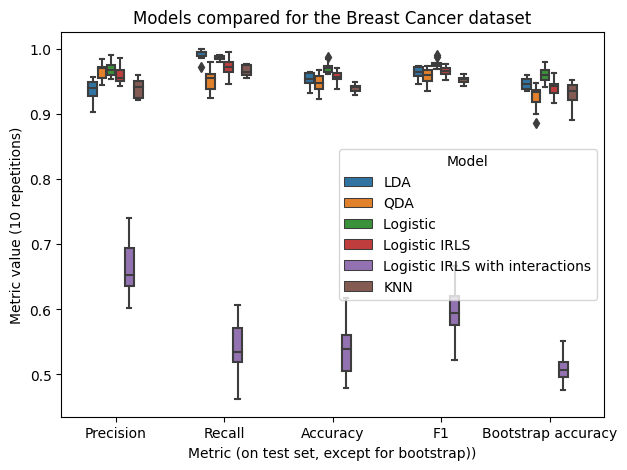

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df, ax=ax, x='metric', y='value', hue='model', width=0.5)

ax.set_title('Models compared for the Breast Cancer dataset')
ax.set_xlabel('Metric (on test set, except for bootstrap))')
ax.set_ylabel(f'Metric value ({REPETITIONS} repetitions)')
ax.set_xticklabels([x.get_text().capitalize() for x in ax.get_xticklabels()])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Model')
fig.savefig('models_comparison_1_breast_cancer.png', dpi=300)
plt.show()

## Dataset 2 - Titanic

Source: [Kaggle](https://www.kaggle.com/c/titanic/data)

Columns:
- PassengerId - ID of the passenger
- Survived - Survival (0 = No, 1 = Yes)
- Pclass - Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- Name - Name of the passenger
- Sex - Sex of the passenger
- Age - Age of the passenger
- SibSp - Number of siblings/spouses aboard the Titanic
- Parch - Number of parents/children aboard the Titanic
- Ticket - Ticket number
- Fare - Passenger fare
- Cabin - Cabin number
- Embarked - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [12]:
import pandas as pd

df = pd.read_csv('titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preparing data

Columns removed due to their nature:
- PassengerId
- Name
- Ticket

Columns removed due to more than 50% missing values:
- Cabin

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

def remove_columns(X, column_names):
    return X.drop(column_names, axis=1)

def remove_missing_columns(X, threshold=0.5):
    missing_values = X.isna().sum() / X.shape[0]
    mask = missing_values > threshold
    X = X.drop(missing_values[mask].index, axis=1)
    return X

def remove_missing_rows(X, Y):
    mask = X['Embarked'].isna()
    X = X[~mask]
    Y = Y[~mask]
    return X, Y

def encode_text(X):
    X.loc[:,'Sex'] = X['Sex'].map({'male': -1, 'female': 1})
    X.loc[:,'Embarked'] = X['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    return X

def impute_missing_age(X):
    column_names = X.columns
    imputer = KNNImputer(n_neighbors=5)
    X = imputer.fit_transform(X)
    return pd.DataFrame(data=X, columns=column_names)

def check_vif(X):
    vif_info = pd.DataFrame()
    vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_info['Column'] = X.columns
    vif_info.sort_values('VIF', ascending=False)
    return vif_info

def one_hot_encode(X, columns):
    encoder = OneHotEncoder(sparse=False, drop='first')
    for column in columns:
        values = X[column].values.reshape(-1, 1)
        encoded = encoder.fit_transform(values)
        encoded = pd.DataFrame(data=encoded, columns=[f'{column}_{value:.0f}' for value in encoder.categories_[0][1:]])
        X = pd.concat([X, encoded], axis=1)
        X = X.drop(column, axis=1)
    return X

def scale_features(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X

Before preparation:

In [14]:
print('Before processing: rows: ', X.shape[0], 'columns: ', X.shape[1])
df.head(2)

Before processing: rows:  569 columns:  21


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


Removing selected columns, imputing or removing rows with missing values, encoding categorical variables.

In [15]:
X, Y = df.drop('Survived', axis=1), df['Survived'].to_numpy()
X = remove_columns(X, ['Name', 'Ticket', 'PassengerId'])
X = remove_missing_columns(X) # will remove the Cabin column
X, Y = remove_missing_rows(X, Y) # remove 2 rows in Embarked column
X = encode_text(X) # sex to -1, 1, embarked one hot encoding
X = impute_missing_age(X) # imputate missing values in Age

/tmp/ipykernel_316317/3366530779.py:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:,'Sex'] = X['Sex'].map({'male': -1, 'female': 1})
/tmp/ipykernel_316317/3366530779.py:24: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:,'Embarked'] = X['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})


Check VIF for multicollinearity as suggested in the received email response.

In [16]:
check_vif(X)

,VIF,Column
0,3.910291,Pclass
1,1.248869,Sex
2,3.828543,Age
3,1.552619,SibSp
4,1.630883,Parch
5,1.716248,Fare
6,1.391786,Embarked


VIF coefficients are low for all variables, so no variables are removed. 

Next, we one-hot encode the categorical variables: Passenger class and port of embarkation.

In [17]:
X = one_hot_encode(X, ['Embarked', 'Pclass'])
X.head(2)

/home/thispc/Data/ub_programs/python_venvs/aml/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/thispc/Data/ub_programs/python_venvs/aml/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Sex,Age,SibSp,Parch,Fare,Embarked_1,Embarked_2,Pclass_2,Pclass_3
0,-1.0,22.0,1.0,0.0,7.2500,0.0,0.0,0.0,1.0
1,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,0.0,0.0


Finally values are scaled.

In [18]:
X = scale_features(X)

After preparation:

In [19]:
print('After processing: rows: ', X.shape[0], 'columns: ', X.shape[1])
print(X[0], Y[0])
print(X[-1], Y[-1])

After processing: rows:  889 columns:  9
[-0.73534203 -0.59093797  0.43135024 -0.47432585 -0.50023975 -0.48271079
 -0.30794088 -0.51087465  0.90032807] 0
[-0.73534203  0.1524324  -0.47519908 -0.47432585 -0.49017322 -0.48271079
  3.24737656 -0.51087465  0.90032807] 0


## Experiments

Test run.

In [20]:
train_models(models, X, Y, metrics, test_size=0.2)

,model,precision,recall,accuracy,f1,bootstrap accuracy
0,LDA,0.689655,0.606061,0.752809,0.645161,0.802888
1,QDA,0.693548,0.651515,0.764045,0.671875,0.817828
2,Logistic,0.727273,0.606061,0.769663,0.661157,0.800771
3,Logistic IRLS,0.727273,0.606061,0.769663,0.661157,0.796303
4,Logistic IRLS with interactions,0.740741,0.606061,0.775281,0.666667,0.821928
5,KNN,0.709677,0.666667,0.775281,0.687500,0.808135


Repeated 10 times to create boxplots.

In [21]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

test_size = 0.2
REPETITIONS = 10

df_list = []
for i in tqdm(range(REPETITIONS)):
    df_list.append(train_models(models, X, Y, metrics, test_size))
df = pd.concat(df_list, ignore_index=True)
df = df.melt(id_vars=['model'], var_name='metric', value_name='value')

100%|██████████| 10/10 [01:11<00:00,  7.18s/it]


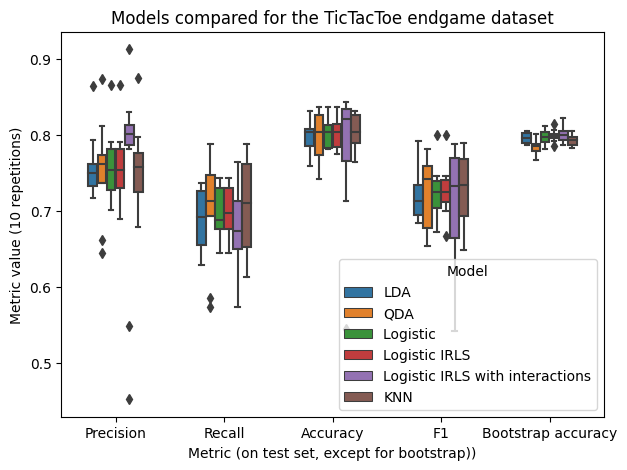

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df, ax=ax, x='metric', y='value', hue='model', width=0.5)

ax.set_title('Models compared for the TicTacToe endgame dataset')
ax.set_xlabel('Metric (on test set, except for bootstrap))')
ax.set_ylabel(f'Metric value ({REPETITIONS} repetitions)')
ax.set_xticklabels([x.get_text().capitalize() for x in ax.get_xticklabels()])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Model')
fig.savefig('models_comparison_2_tictactoe.png', dpi=300)
plt.show()